<a href="https://colab.research.google.com/github/Evans-Sense/pet/blob/main/Hometask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание
Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

Цель:
На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомиться со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.




Описание/Пошаговая инструкция выполнения домашнего задания:
Часть 1. EDA и Preprocessing.

Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
Проведите EDA, чтобы познакомиться с признаками;
Преобразуйте все признаки в числовые подходящими методами;
Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/german-credit")

print("Path to dataset files:", path)

100%|██████████| 10.9k/10.9k [00:00<00:00, 16.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/german-credit/versions/1


In [3]:
import pandas as pd
import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/root/.cache/kagglehub/datasets/uciml/german-credit/versions/1/german_credit_data.csv


In [4]:
df= pd.read_csv('/root/.cache/kagglehub/datasets/uciml/german-credit/versions/1/german_credit_data.csv')

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [6]:
df.nunique()

,0
Unnamed: 0,1000
Age,53
Sex,2
Job,4
Housing,3
Saving accounts,4
Checking account,3
Credit amount,921
Duration,33
Purpose,8


In [7]:
df.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [9]:
df_encoded = df.copy()

# Identify categorical columns (object dtype)
categorical_cols = df_encoded.select_dtypes(include='object').columns

# Handle missing values in 'Saving accounts' and 'Checking account'
df_encoded['Saving accounts'] = df_encoded['Saving accounts'].fillna('No saving accounts')
df_encoded['Checking account'] = df_encoded['Checking account'].fillna('No checking account')

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=False)

print("DataFrame after encoding categorical features:")
print(df_encoded.head())
print("\nInformation about the encoded DataFrame:")
df_encoded.info()

DataFrame after encoding categorical features:
   Unnamed: 0  Age  Job  Credit amount  Duration  Sex_female  Sex_male  \
0           0   67    2           1169         6       False      True   
1           1   22    2           5951        48        True     False   
2           2   49    1           2096        12       False      True   
3           3   45    2           7882        42       False      True   
4           4   53    2           4870        24       False      True   

   Housing_free  Housing_own  Housing_rent  ...  Checking account_moderate  \
0         False         True         False  ...                      False   
1         False         True         False  ...                       True   
2         False         True         False  ...                      False   
3          True        False         False  ...                      False   
4          True        False         False  ...                      False   

   Checking account_rich  Purpose_busin

In [10]:
from sklearn.preprocessing import StandardScaler

# Drop the 'Unnamed: 0' column as it's likely an identifier and not useful for clustering
df_scaled = df_encoded.drop(columns=['Unnamed: 0']).copy()

# Identify numerical columns for scaling (excluding boolean columns)
numerical_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to the numerical columns
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

print("DataFrame after scaling numerical features:")
print(df_scaled.head())
print("\nInformation about the scaled DataFrame:")
df_scaled.info()

DataFrame after scaling numerical features:
        Age       Job  Credit amount  Duration  Sex_female  Sex_male  \
0  2.766456  0.146949      -0.745131 -1.236478       False      True   
1 -1.191404  0.146949       0.949817  2.248194        True     False   
2  1.183312 -1.383771      -0.416562 -0.738668       False      True   
3  0.831502  0.146949       1.634247  1.750384       False      True   
4  1.535122  0.146949       0.566664  0.256953       False      True   

   Housing_free  Housing_own  Housing_rent  \
0         False         True         False   
1         False         True         False   
2         False         True         False   
3          True        False         False   
4          True        False         False   

   Saving accounts_No saving accounts  ...  Checking account_moderate  \
0                                True  ...                      False   
1                               False  ...                       True   
2                          

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA with all components to analyze explained variance
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

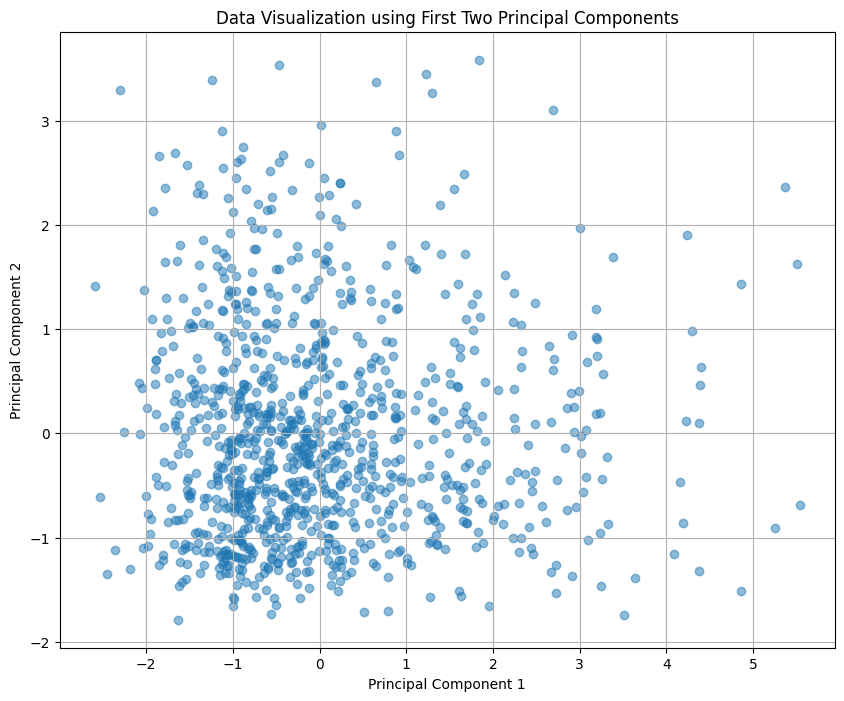

In [16]:
import matplotlib.pyplot as plt

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Visualization using First Two Principal Components')
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


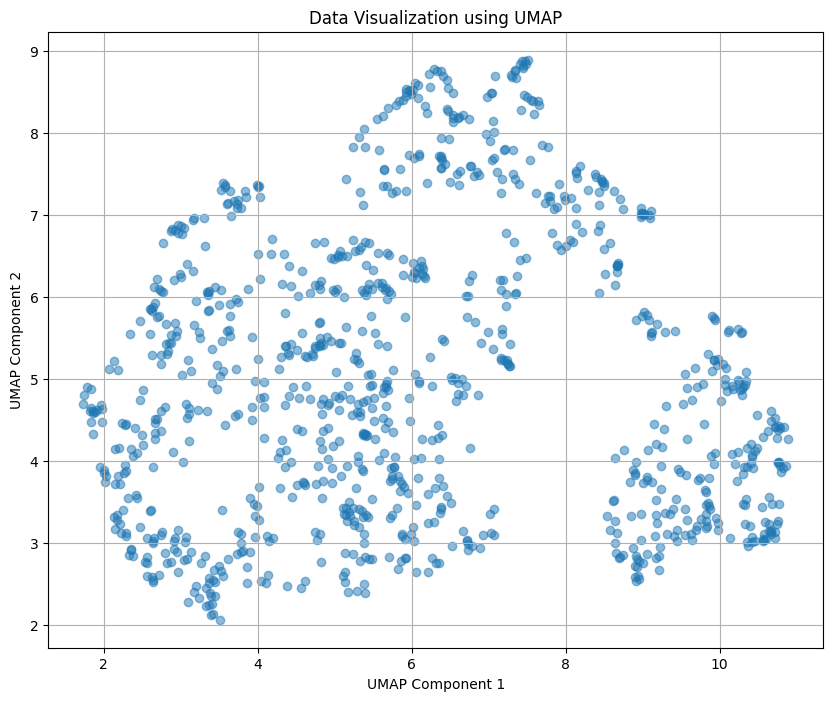

In [26]:
import umap
import matplotlib.pyplot as plt

# Initialize UMAP with 2 components
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the scaled data
df_umap = umap_reducer.fit_transform(df_scaled)

# Create a scatter plot of the UMAP-transformed data
plt.figure(figsize=(10, 8))
plt.scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.5)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('Data Visualization using UMAP')
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


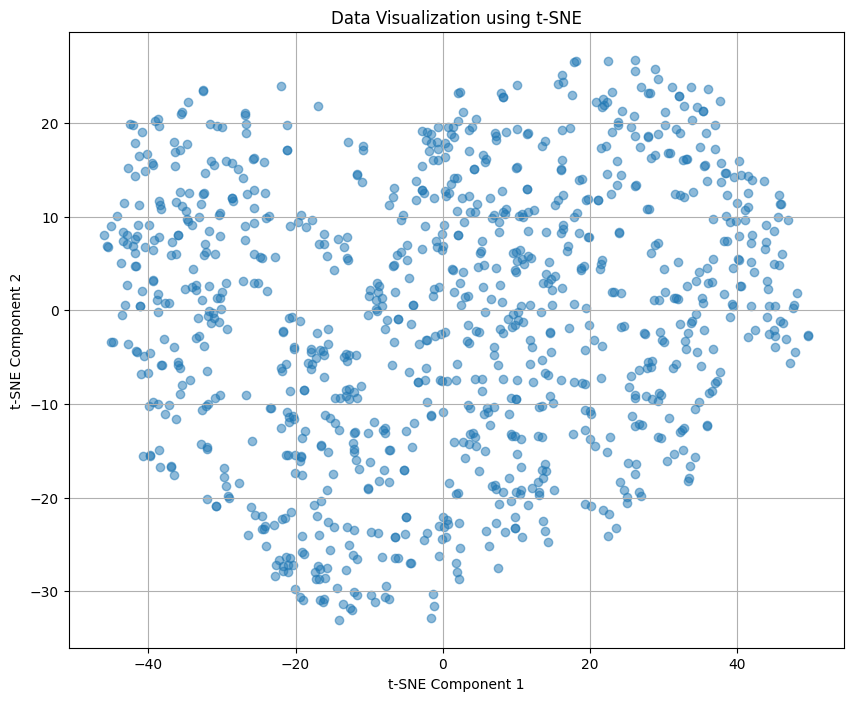

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Initialize t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# Fit and transform the scaled data
df_tsne = tsne.fit_transform(df_scaled)

# Create a scatter plot of the t-SNE-transformed data
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Data Visualization using t-SNE')
plt.grid(True)
plt.show()

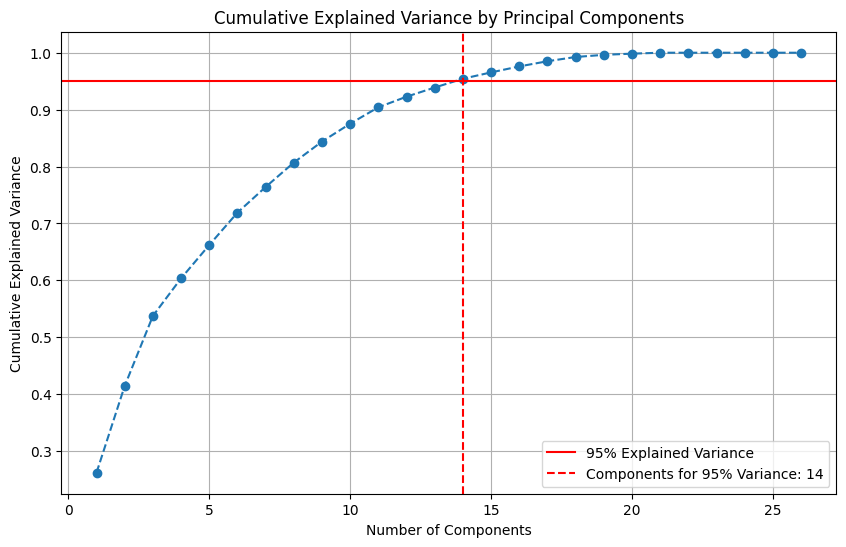

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA with all components to analyze explained variance
pca = PCA()
pca.fit(df_scaled)

# Calculate cumulative explained variance
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=np.argmax(cum_var_exp >= 0.95) + 1, color='r', linestyle='--', label=f'Components for 95% Variance: {np.argmax(cum_var_exp >= 0.95) + 1}')
plt.legend()
plt.show()


Часть 2. Моделирование.

Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.


In [54]:
from sklearn.cluster import KMeans
inertia = []
for i in range(1,21): # Changed range to include 20 clusters
    kmeans = KMeans(n_clusters=i, random_state=10, n_init=10).fit(df_scaled)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

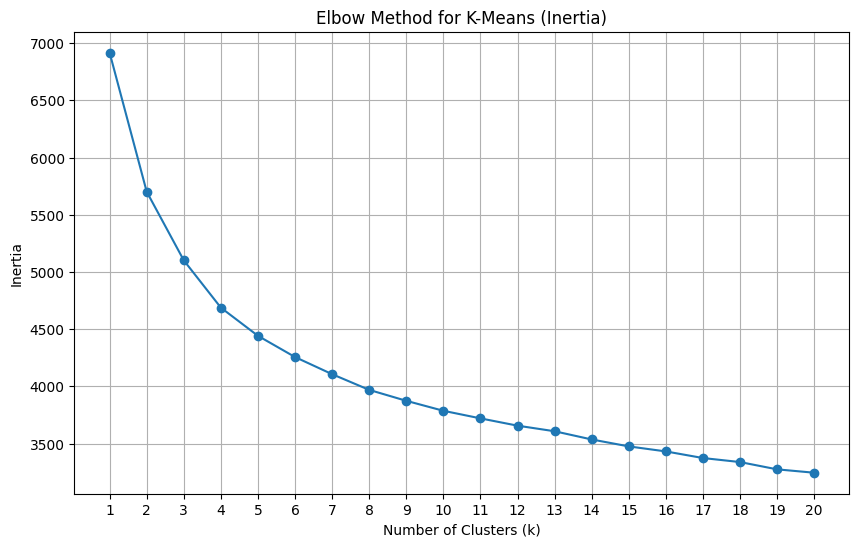

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1,21), inertia, marker='o'); # Updated range for plotting
plt.title('Elbow Method for K-Means (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

In [56]:
D = []
for i in range(1,19): # Updated range based on inertia_list length (up to 20 clusters)
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)

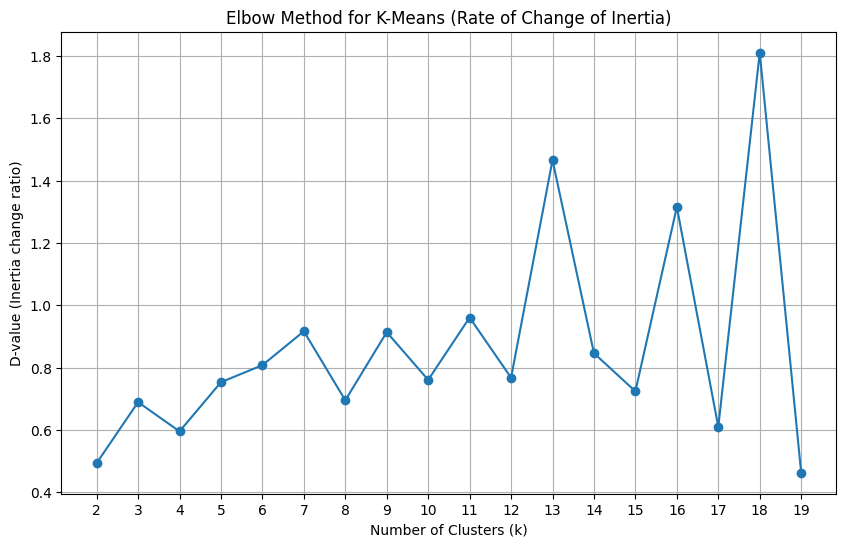

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(2,20), D, marker='o'); # Updated range for plotting D values
plt.title('Elbow Method for K-Means (Rate of Change of Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('D-value (Inertia change ratio)')
plt.grid(True)
plt.xticks(range(2, 20))
plt.show()

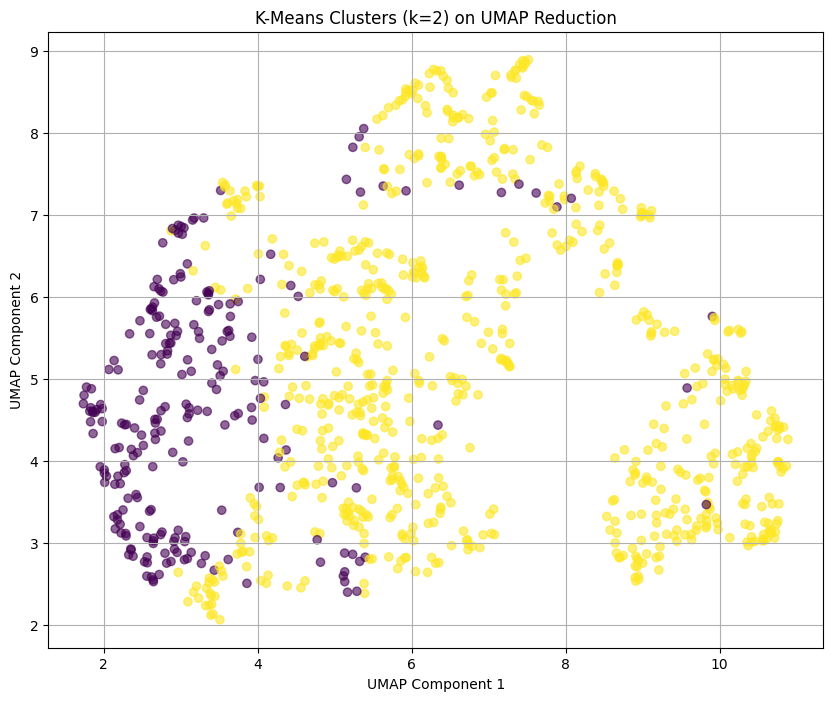

In [58]:
kmeans = KMeans(n_clusters=2, random_state=10, n_init=10).fit(df_scaled)
labels = kmeans.labels_
plt.figure(figsize=(10, 8))
plt.scatter(df_umap[:,0], df_umap[:,1], c=labels, cmap='viridis', alpha=0.6);
plt.title('K-Means Clusters (k=2) on UMAP Reduction')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

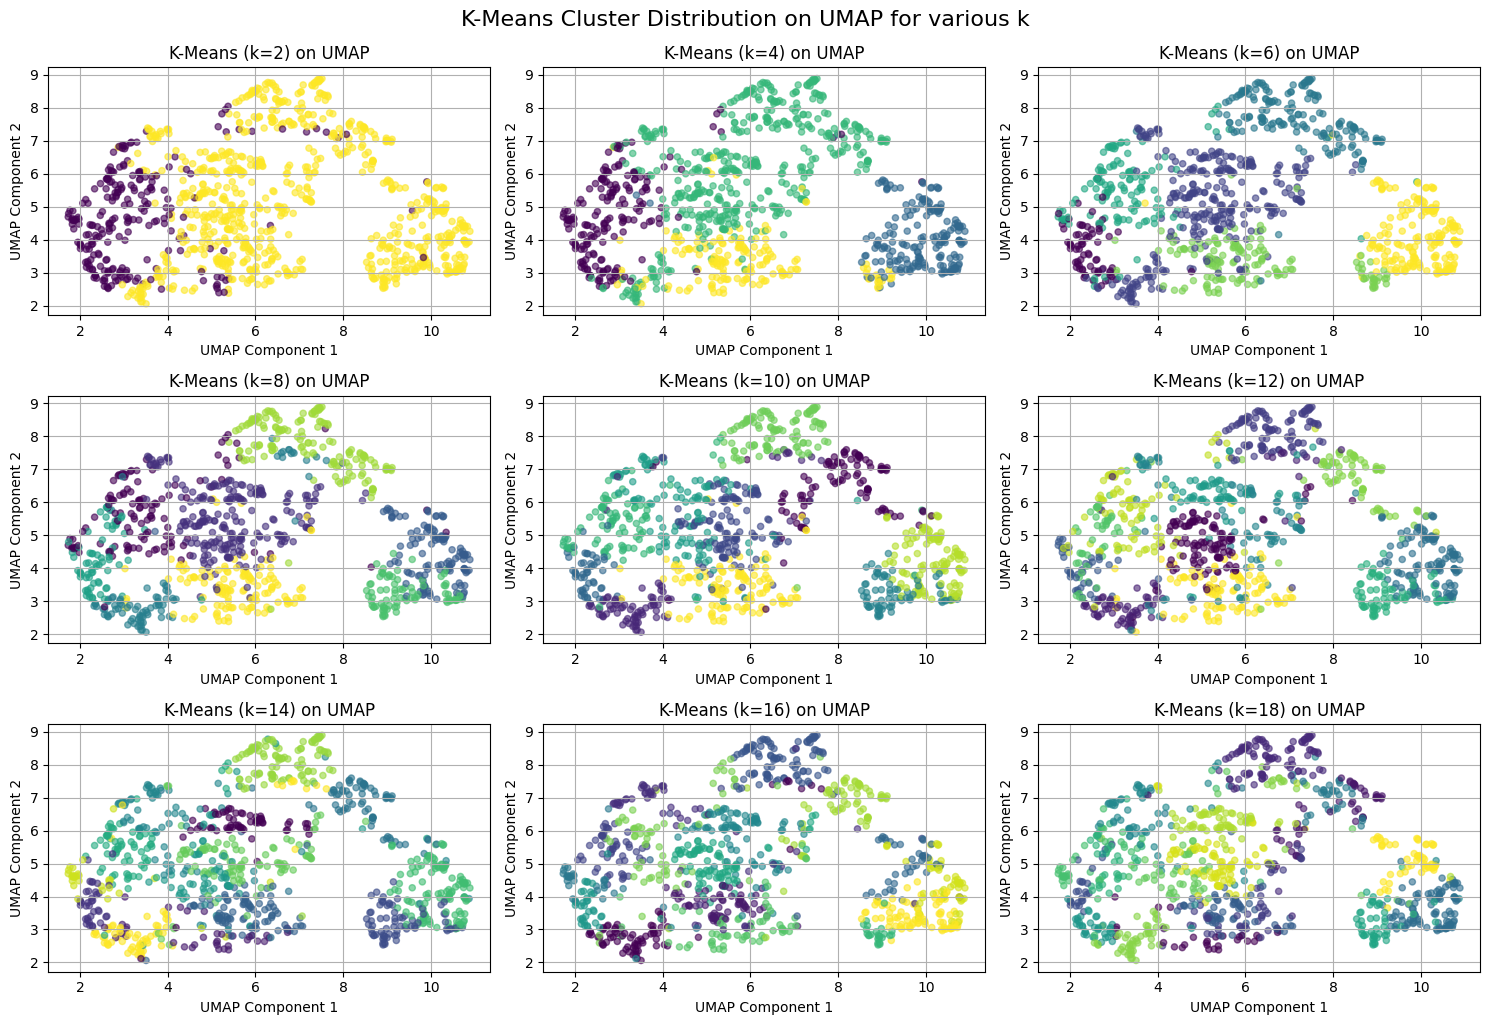

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of n_clusters to visualize
cluster_sizes = range(2, 20, 2) # From 2 to 7 clusters

plt.figure(figsize=(15, 10)) # Adjust figure size for a grid of plots

for i, k in enumerate(cluster_sizes):
    # Fit K-Means for the current k
    kmeans = KMeans(n_clusters=k, random_state=10, n_init=10).fit(df_scaled)
    labels = kmeans.labels_

    # Create a subplot for each k
    plt.subplot(3, 3, i + 1) # Arrange in a 2x3 grid (adjust based on cluster_sizes length)
    plt.scatter(df_umap[:, 0], df_umap[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20); # 's' for smaller points
    plt.title(f'K-Means (k={k}) on UMAP')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True)

plt.tight_layout() # Adjust subplot params for a tight layout
plt.suptitle('K-Means Cluster Distribution on UMAP for various k', y=1.02, fontsize=16) # Add a main title
plt.show()

На основании графиков наиболее информативны 4 и 8 кластеров

In [71]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

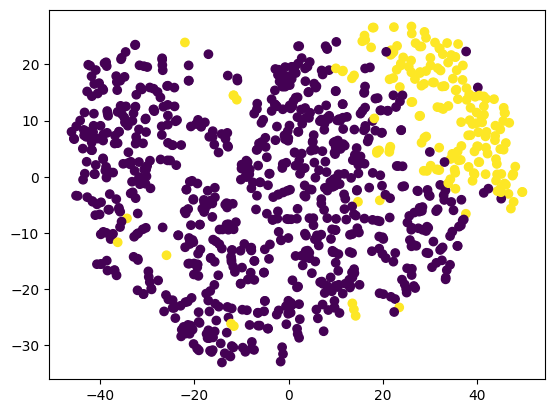

In [73]:
agg = AgglomerativeClustering(n_clusters=2).fit(df_scaled)
labels = agg.labels_

plt.scatter(df_tsne[:,0], df_tsne[:,1], c=labels);

In [75]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(df_scaled)
    labels = agg.labels_
    score = silhouette_score(df_scaled, labels)
    silhouette.append(score)

100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


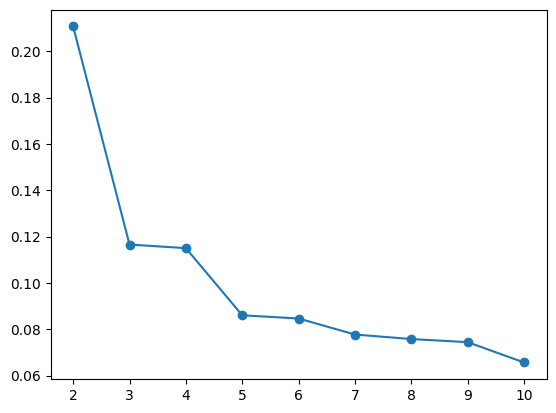

In [76]:
plt.plot(range(2,11), silhouette, marker='o');

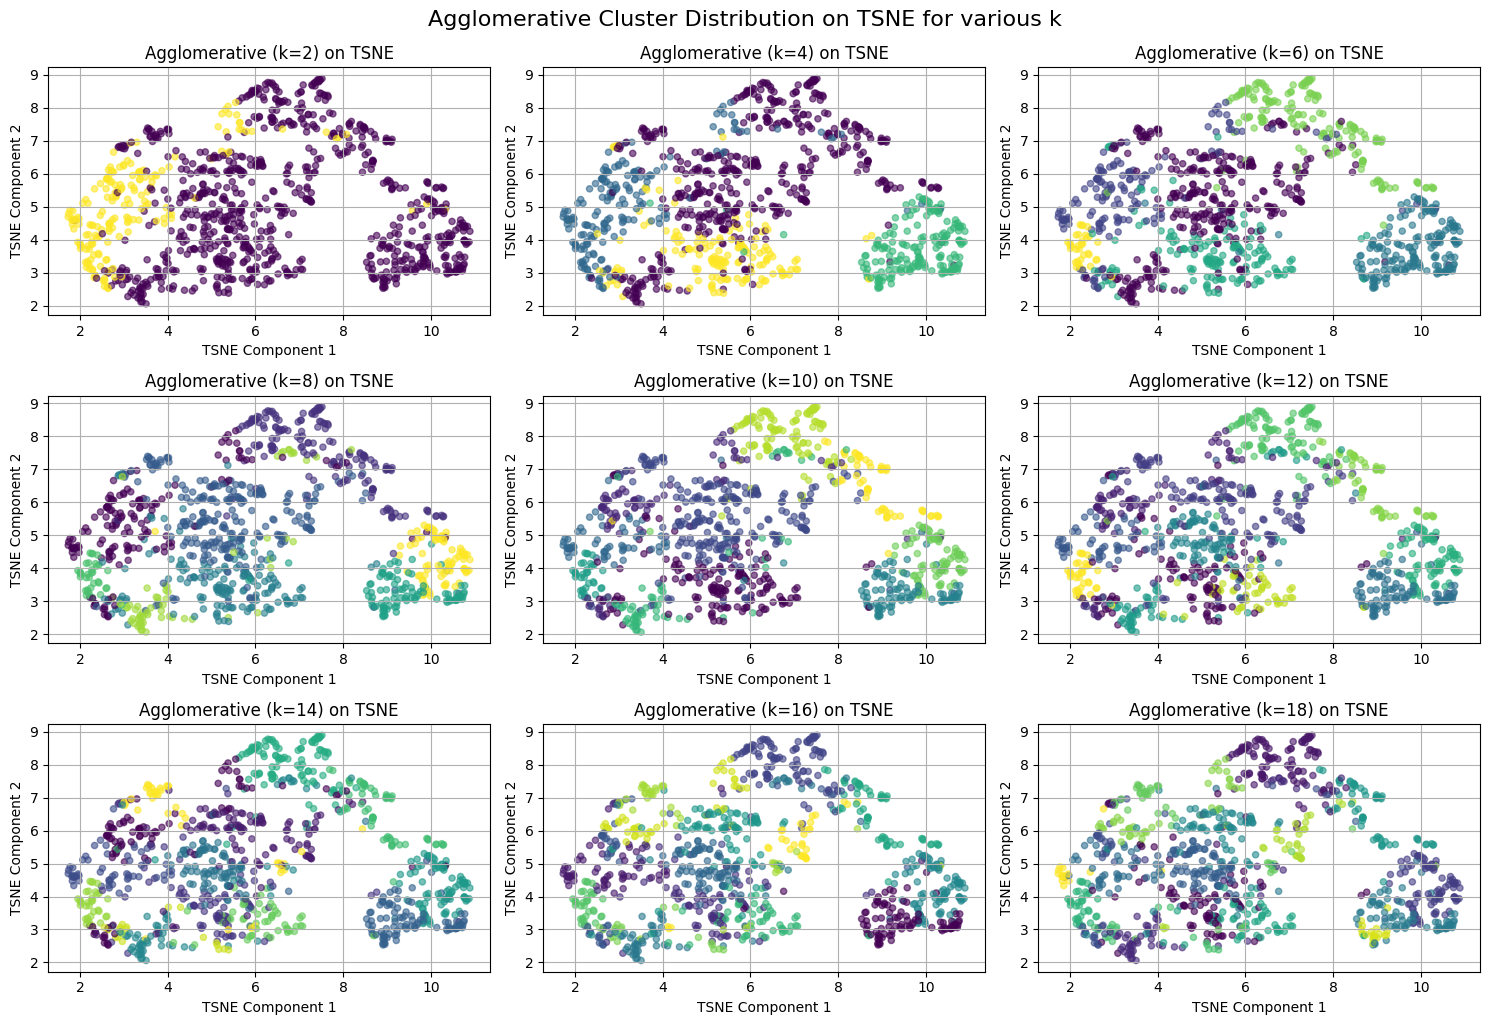

In [78]:
# Define a range of n_clusters to visualize
cluster_sizes = range(2, 20, 2) # From 2 to 7 clusters

plt.figure(figsize=(15, 10)) # Adjust figure size for a grid of plots

for i, k in enumerate(cluster_sizes):

    agg = AgglomerativeClustering(n_clusters=k).fit(df_scaled)
    labels = agg.labels_

    # Create a subplot for each k
    plt.subplot(3, 3, i + 1) # Arrange in a 2x3 grid (adjust based on cluster_sizes length)
    plt.scatter(df_umap[:, 0], df_umap[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20); # 's' for smaller points
    plt.title(f'Agglomerative (k={k}) on TSNE')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.grid(True)

plt.tight_layout() # Adjust subplot params for a tight layout
plt.suptitle('Agglomerative Cluster Distribution on TSNE for various k', y=1.02, fontsize=16) # Add a main title
plt.show()

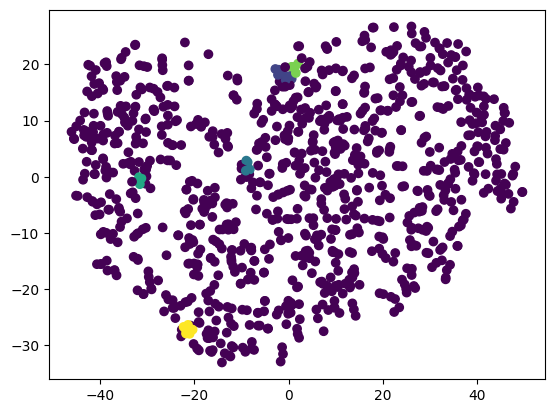

In [81]:
dbscan = DBSCAN().fit(df_scaled)
labels = dbscan.labels_

plt.scatter(df_tsne[:,0], df_tsne[:,1], c=labels);

In [82]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4])

In [83]:
uniq_labels = np.unique(labels)
uniq_labels

array([-1,  0,  1,  2,  3,  4])

In [84]:
n_clusters = len(uniq_labels[uniq_labels != -1])
n_clusters

5

In [85]:
silhouette = []
clusters = []
eps_range = np.arange(0.1,2,0.1)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i).fit(df_scaled)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(df_scaled, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)

100%|██████████| 19/19 [00:01<00:00, 11.86it/s]


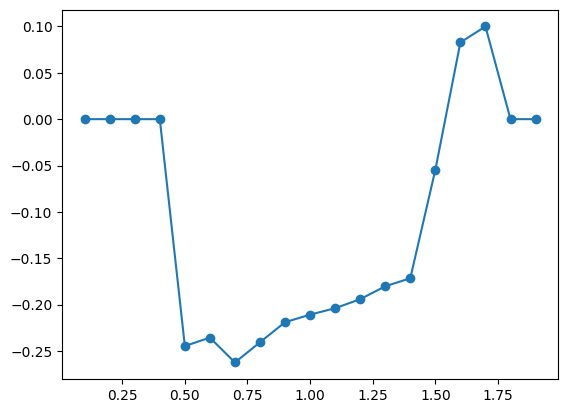

In [86]:
plt.plot(eps_range, silhouette, marker='o');

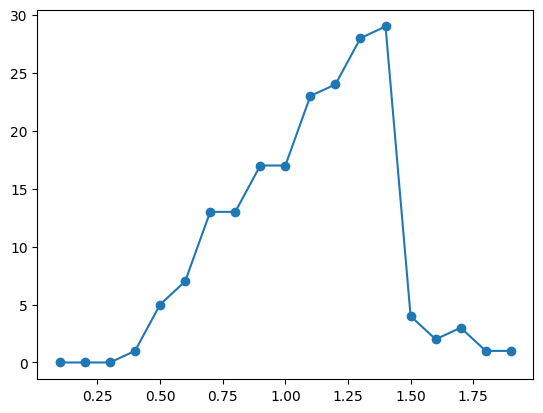

In [87]:
plt.plot(eps_range, clusters, marker='o');

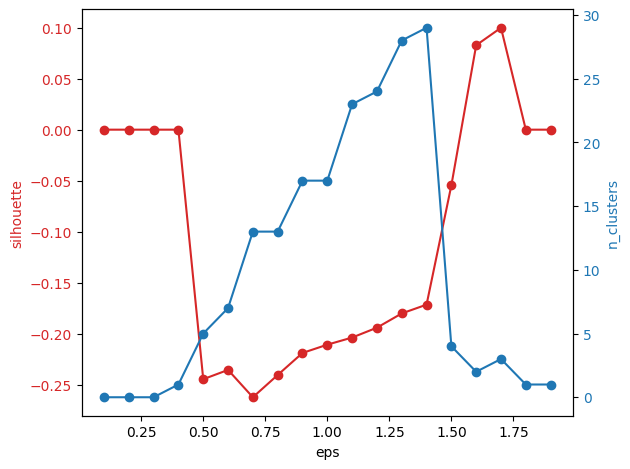

In [88]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(eps_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(eps_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

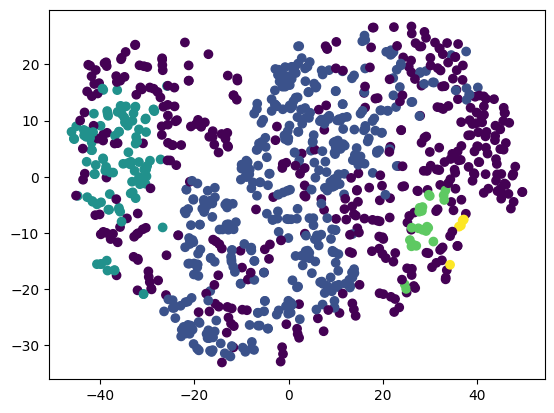

In [96]:
dbscan = DBSCAN(eps=1.53).fit(df_scaled)
labels = dbscan.labels_

plt.scatter(df_tsne[:,0], df_tsne[:,1], c=labels);

In [97]:
uniq_labels = np.unique(labels)
print(uniq_labels)

n_clusters = len(uniq_labels[uniq_labels != -1])
print(n_clusters)

[-1  0  1  2  3]
4


(array([429.,   0., 439.,   0.,   0., 104.,   0.,  23.,   0.,   5.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <BarContainer object of 10 artists>)

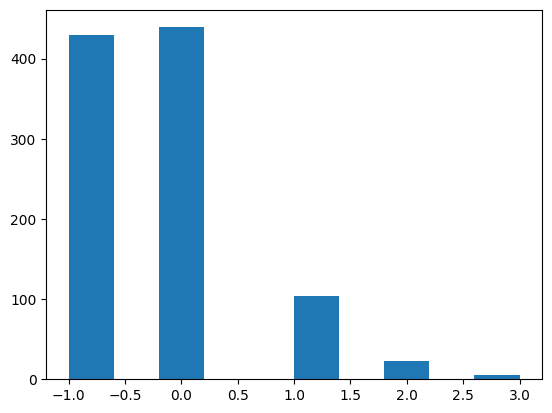

In [101]:
plt.hist(labels)


Часть 3. Интерпретация.

Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?